### Modelling statistical learning

To explore the effect of sleep on statistical learning, Durrant et al. (2011) constructed two types of sequence, both made up of regular tones at differing frequencies. One type had a structure in which the preceding two tones determined the next, except for a few transitions which were random to avoid repetition. The other type was the reverse – most transitions were random. After listening to a structured sequence, participants were tested on their ability distinguish short structured and unstructured sequences. Delayed recall was then tested, after a night’s sleep for one group, and after a waking rest for the other. Durrant et al. (2011) found that sleep improved performance more than waking rest, suggesting systems consolidation promotes statistical learning.

Here, we generate a set of sequences based on the transition structure in Durrant et al. (2011). A model with the GPT-2 architecture is trained from scratch on the structured sequences only. At the end of each epoch of the training, the perplexity is calculated for a two test sets of structured and unstructured sequences. We find that the difference in perplexity of these two sets increases over time, corresponding to improved ability to distinguish them. In addition, outputs from the trained model are structured in the same way as the training data.

#### Imports:

In [2]:
import sys
sys.path.append('../scripts/')

import pandas as pd
import random
import logging
from random import shuffle
from matplotlib import pyplot as plt
from statistical_learning_utils import *
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
import os
import glob
import evaluate
from evaluate import load
import numpy as np
import gc
import re
from gpt import *

os.environ['WANDB_MODE'] = 'disabled'
random.seed(1)

/nfs/nhome/live/espens/.pyenv/versions/3.11.5/envs/my_venv_3115/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Generate structured and unstructured data:

In [2]:
def get_random_sequence():
    start = [random.randint(1,5),random.randint(1,5)]
    for i in range(50):
        next_val = random.randint(1,5)
        start.append(next_val)
    return ','.join([str(i) for i in start])

text_file = open("train.txt", "w")
walks = [get_sequence() for i in range(2000)]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("val.txt", "w")
walks = [get_sequence() for i in range(100)]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("structured_test.txt", "w")
walks = [get_sequence() for i in range(100)]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("unstructured_test.txt", "w")
walks = [get_random_sequence() for i in range(100)]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

#### Train generative model

Train GPT-2 from scratch on dataset created above.

In [3]:
def train_model_script(num_epochs=3,
                       output_dir='outputs',
                       lr=5e-05,
                       seed=0):
    gc.collect()
    train_path = 'train.txt'
    test_path = 'val.txt'
    ! python3 ../scripts/run_clm.py \
        --model_type 'gpt2' \
        --config_name 'gpt2-medium' \
        --tokenizer_name 'gpt2' \
        --train_file {train_path} \
        --validation_file {test_path} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'epoch' \
        --learning_rate {lr} \
        --seed {seed} \
        --block_size 100
            

In [4]:
for trial in range(0, 3):

    !rm -rf durrant_{trial}
    !mkdir durrant_{trial}

    # Train the model
    train_model_script(num_epochs=3,
                       output_dir=f'durrant_{trial}',
                       lr=1e-05,
                       seed=trial)


03/28/2025 14:17:39 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/28/2025 14:17:39 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Test model

In [3]:
structured_test_file = "structured_test.txt"
unstructured_test_file = "unstructured_test.txt"

In [4]:
checkpoints = os.listdir(f'./durrant_0')
# Extract numbers using regex and convert to integers
checkpoint_numbers = sorted([int(re.search(r"\d+", chk).group()) for chk in checkpoints if re.search(r"\d+", chk)])

In [5]:
perplexity = load("perplexity", module_type="metric")

all_structured = []
all_unstructured = []

for trial in range(0, 3):    
    
    perplexity_structured = []
    perplexity_unstructured = []
    
    for ep in checkpoint_numbers:
        pattern = os.path.join(f'./durrant_{trial}', f'checkpoint-{ep}')
        print(pattern)
        model_dir = glob.glob(pattern)[0]

        with open(structured_test_file, 'r') as file:
            structured_test_examples = file.readlines()
        results = perplexity.compute(model_id=model_dir,
                             add_start_token=False,
                             predictions=structured_test_examples)['mean_perplexity']
        perplexity_structured.append(results)

        with open(unstructured_test_file, 'r') as file:
            unstructured_test_examples = file.readlines()
        results = perplexity.compute(model_id=model_dir,
                             add_start_token=False,
                             predictions=unstructured_test_examples)['mean_perplexity']
        perplexity_unstructured.append(results)

    all_unstructured.append(perplexity_unstructured)
    all_structured.append(perplexity_structured)

./durrant_0/checkpoint-2079


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.12it/s]


./durrant_0/checkpoint-4158


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.18it/s]


./durrant_0/checkpoint-6237


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.11it/s]


./durrant_1/checkpoint-2079


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.22it/s]


./durrant_1/checkpoint-4158


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.26it/s]


./durrant_1/checkpoint-6237


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.13it/s]


./durrant_2/checkpoint-2079


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.17it/s]


./durrant_2/checkpoint-4158


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.17it/s]


./durrant_2/checkpoint-6237


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.22it/s]


#### Plot perplexity against time

Average structured perplexity: [1.56307914 1.38219773 1.36905758]
SEM structured perplexity: [0.05779834 0.03903233 0.05650875]
Average unstructured perplexity: [3.64011718 4.5776732  5.16486048]
SEM unstructured perplexity: [0.34210533 0.34426383 0.41295866]


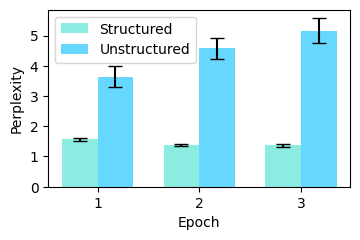

In [15]:
# Convert lists to numpy arrays for easier computation
structured_array = np.array(all_structured)
unstructured_array = np.array(all_unstructured)

# Calculate the average perplexity for each epoch across the three trials
avg_structured = np.mean(structured_array, axis=0)
avg_unstructured = np.mean(unstructured_array, axis=0)

# Calculate the SEM for each epoch across the three trials
sem_structured = np.std(structured_array, axis=1) / np.sqrt(structured_array.shape[0])
sem_unstructured = np.std(unstructured_array, axis=1) / np.sqrt(unstructured_array.shape[0])

# Print the averages and SEM
print("Average structured perplexity:", avg_structured)
print("SEM structured perplexity:", sem_structured)
print("Average unstructured perplexity:", avg_unstructured)
print("SEM unstructured perplexity:", sem_unstructured)

# Define the number of epochs
epochs = [1, 2, 3]

# Create the bar chart
fig, ax = plt.subplots(figsize=(3.9, 2.3))

# Bar width
bar_width = 0.35

# Set positions of the bars on the x-axis
r1 = np.arange(len(epochs))
r2 = [x + bar_width for x in r1]

# Create bars for structured perplexity with error bars
ax.bar(r1, avg_structured, color='turquoise', alpha=0.6, width=bar_width, yerr=sem_structured, 
       capsize=5, label='Structured')

# Create bars for unstructured perplexity with error bars
ax.bar(r2, avg_unstructured, color='deepskyblue', alpha=0.6, width=bar_width, yerr=sem_unstructured, 
       capsize=5, label='Unstructured')

# Add labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
ax.set_xticks([r + bar_width / 2 for r in range(len(epochs))])
ax.set_xticklabels(epochs)

# Add legend
ax.legend()

# Show the plot
plt.savefig('perplexities.png', dpi=300, bbox_inches='tight')
plt.show()


#### Plot transition structure of generated data

In [9]:
# Load the model and tokenizer
model = GPT2LMHeadModel.from_pretrained('durrant_0/')
tokenizer = AutoTokenizer.from_pretrained('durrant_0/')

# Set model to evaluation mode
model.eval()

data = ""
for num in range(10):
    for i in range(1, 6):
        input_ids = tokenizer(str(i), return_tensors="pt").input_ids
        out = model.generate(input_ids, temperature=0.1, max_length=200, do_sample=True)
        out = tokenizer.decode(out[0], skip_special_tokens=True)
        data += out

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask

In [10]:
data = data.replace('\n', ',')

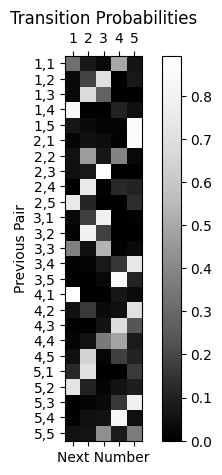

In [11]:
data_list = [int(x[0]) for x in data.split(',') if x]

# Initialize a dictionary to hold the transition counts
transition_counts = {((i, j), k): 0 for i in range(1, 6) for j in range(1, 6) for k in range(1, 6)}

# Populate the transition counts
for i in range(len(data_list) - 2):
    prev_pair = (data_list[i], data_list[i+1])
    next_num = data_list[i+2]
    transition_counts[(prev_pair, next_num)] += 1

# Calculate probabilities from counts
transition_probabilities = {}
for key, value in transition_counts.items():
    prev_pair = key[0]
    total_transitions = sum([transition_counts[(prev_pair, k)] for k in range(1, 6)])
    if total_transitions > 0:
        transition_probabilities[key] = value / total_transitions
    else:
        transition_probabilities[key] = 0

# Prepare data for plotting
plot_data = np.zeros((25, 5))  # 25 possible pairs and 5 possible next numbers
for i, pair in enumerate(transition_counts.keys()):
    y_index = (pair[0][0] - 1) * 5 + (pair[0][1] - 1)
    x_index = pair[1] - 1
    plot_data[y_index, x_index] = transition_probabilities[pair]

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(plot_data, cmap='Greys_r')

# Set ticks
ax.set_xticks(range(5))
ax.set_xticklabels(range(1, 6))
ax.set_yticks(range(25))
ax.set_yticklabels([f'{i//5+1},{i%5+1}' for i in range(25)])

ax.set_xlabel('Next Number')
ax.set_ylabel('Previous Pair')
ax.set_title('Transition Probabilities')

plt.colorbar(cax)
plt.savefig('trps.png', dpi=500)
plt.show()